## Text Preprocessing and Sentiment Analysis
wallstreetBets Dataset is too large (more than 1GB) for a computer's memory to handle. So, we will have to process an entire data set chunk by chunk, instead of a single go all at once.


In [1]:
import pandas as pd
# importing wallstreet Data
chunks = pd.read_json('Datasets/wsbData.json', lines=True, chunksize = 10000)
# importing stock market data
stocksDF=pd.read_csv('Datasets/all_stocks_5yr.csv')
companyNames=stocksDF['Name'].unique().tolist()

for wsDF in chunks:
    # printing the columns and their datatypes
    print(wsDF.info())
    # Printing the First few rows of wall street data set
    print(wsDF.head(5))
    break


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   body                    10000 non-null  object 
 1   score_hidden            8520 non-null   float64
 2   archived                8520 non-null   float64
 3   name                    8520 non-null   object 
 4   author                  10000 non-null  object 
 5   downs                   8520 non-null   float64
 6   created_utc             10000 non-null  int64  
 7   subreddit_id            10000 non-null  object 
 8   link_id                 10000 non-null  object 
 9   parent_id               10000 non-null  object 
 10  score                   10000 non-null  int64  
 11  retrieved_on            10000 non-null  int64  
 12  controversiality        10000 non-null  int64  
 13  gilded                  10000 non-null  int64  
 14  id                      10000 non-null 

## Preprocessing wallstreetBets data:
All preprocessing of wallStreet will be done in the `textPreprocessing()` function.
The only needed attribute for our project is the `body` colomn.

In [3]:
import re
def cleanTxt(text):

    # Removing @ mentions
    text=re.sub(r'@[A-Za-z0-9]+','',text)

    # removing hashtags
    text=re.sub(r'#','',text)
    #removing the hyper-link
    text=re.sub(r'https?:\/\/\S+','',text)
    text=re.sub(r'http?:\/\/\S+','',text)

    return text



def textPreprocessing(df):
    """
    text Preprocessing method does the preprocessing needed for the wallStreet bets dataset.
    :param df: the dataframe chunck from wallStreet bets dataset.
    :return: has no return.
    """
    # step 1: extracting the necessary columns:
    df_comments=pd.DataFrame(df['body'])
    # Droping all deleted comments
    df_comments= df_comments.drop(df_comments[(df_comments['body'] =='[deleted]') ].index)
    df_comments= df_comments.drop(df_comments[(df_comments['body'] =='[removed]') ].index)
    # text cleaning
    df_comments['body']=df_comments['body'].apply(cleanTxt)
    df_comments=df_comments.dropna()

    return df_comments



## Sentiment Analysis
In order to analys wall street reddit comments we will use an NLP algorithm known as sentiment analysis mostly focus on defining opinions, attitudes, and even emoticons in a corpus of texts. The task of sentiment analysis will be done using `TextBlob package`.

In [4]:
from textblob import TextBlob
def wsSentiment(txt):
    """
    setiment analysis for S&P companies in a dataframe
    :param df: the dataframe chunck from wallStreet bets dataset.
    :return: dataframe conaining comapany names, sentiment, sentiment polarity, sentiment subjective4.
    """
    newdf=pd.DataFrame()
    newdf['Name']=[n for n in companyNames if str (' '+n+' ') in txt]
    if newdf.shape[0]==0:
        return None
    polarityNum=TextBlob(txt).sentiment.polarity
    newdf['Polarity']=[polarityNum for n in range(newdf.shape[0]) ]
    if polarityNum <0:
        newdf['Sentiment']=['Negative' for n in range(newdf.shape[0]) ]
    elif polarityNum >0:
        newdf['Sentiment']=['Positive' for n in range(newdf.shape[0]) ]
    else:
        newdf['Sentiment']=['Neutral' for n in range(newdf.shape[0]) ]
    subj=TextBlob(txt).sentiment.subjectivity
    newdf['Subjectivity']=[subj for n in range(newdf.shape[0]) ]
    return newdf



In [2]:
sentimentDF=pd.DataFrame()
i=1
for wsDF in chunks:
    # print(wsDF.head())
    df= textPreprocessing(wsDF)
    # Freeing memory of wsDf DataFrame
    del wsDF
    for txt in df['body'] :
        retDF=wsSentiment(txt)
        if retDF is not None:
            sentimentDF=pd.concat([sentimentDF,retDF])
            del retDF
    del df

sentimentDF.to_csv('Sentiment.csv')

  Name  Polarity Sentiment  Subjectivity
0  AMD  0.024790  Positive      0.330976
1    A  0.000000   Neutral      0.000000
2    A -0.307407  Negative      0.529630
3    A  0.135714  Positive      0.398980
4   IR  0.138889  Positive      0.350000
          Sentiment
Positive      70156
Neutral       43236
Negative      42031


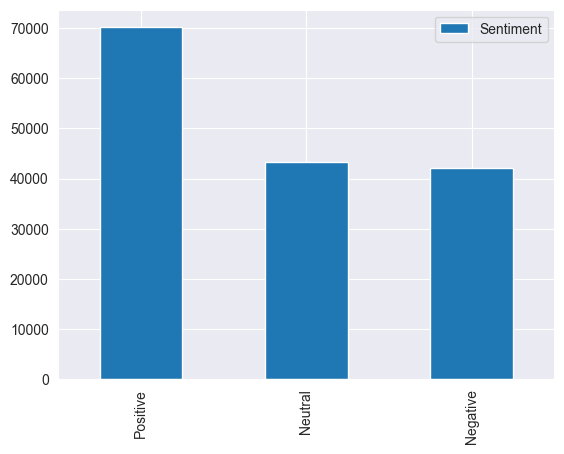

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sentimentDF=pd.read_csv('Sentiment.csv')
sentimentDF = sentimentDF.drop('Unnamed: 0', axis=1)
print(sentimentDF.head())
sentiments_counts=pd.DataFrame(sentimentDF['Sentiment'].value_counts())
print(sentiments_counts.head())
sentiments_counts.plot(kind='bar')
plt.show()

## Data Preprocessing on Stock Data.

In [5]:
from sklearn.preprocessing import StandardScaler
# Check for missing values
print(stocksDF.isnull().sum())
# drop nan rows
stocksDF=stocksDF.dropna()

# Convert the date column to datetime format
stocksDF['date']=pd.to_datetime(stocksDF['date'],format="%Y-%m-%d")

# Check for duplicates
print('duplicates: ',stocksDF.duplicated().sum())
# no duplicated values

print(stocksDF.head())
# print(stocksDF.info())

# Standardizing the data helps to bring all the columns to the same scale
scaler = StandardScaler()
stocksDF[['open', 'high', 'low', 'close', 'volume']] = scaler.fit_transform(stocksDF[['open', 'high', 'low', 'close', 'volume']])
print(stocksDF.head())


date      0
open      0
high      0
low       0
close     0
volume    0
Name      0
dtype: int64
duplicates:  0
        date   open   high    low  close    volume Name
0 2013-02-08  15.07  15.12  14.63  14.75   8407500  AAL
1 2013-02-11  14.89  15.01  14.26  14.46   8882000  AAL
2 2013-02-12  14.45  14.51  14.10  14.27   8126000  AAL
3 2013-02-13  14.30  14.94  14.25  14.66  10259500  AAL
4 2013-02-14  14.94  14.96  13.16  13.99  31879900  AAL
        date      open      high       low     close    volume Name
0 2013-02-08 -0.697826 -0.699115 -0.700735 -0.701244  0.469952  AAL
1 2013-02-11 -0.699674 -0.700235 -0.704569 -0.704221  0.524532  AAL
2 2013-02-12 -0.704192 -0.705326 -0.706227 -0.706172  0.437572  AAL
3 2013-02-13 -0.705733 -0.700948 -0.704672 -0.702168  0.682981  AAL
4 2013-02-14 -0.699161 -0.700744 -0.715967 -0.709047  3.169896  AAL


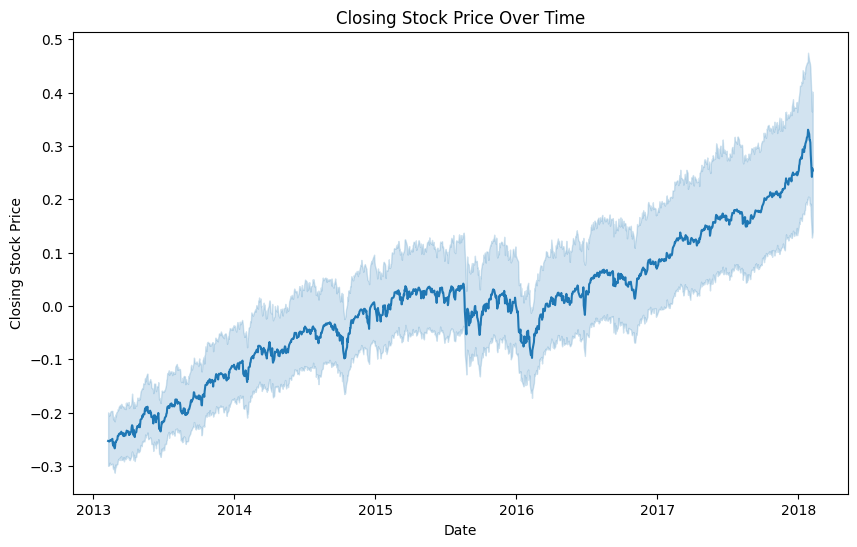

In [8]:
# Line chart of closing stock price over time
plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='close', data=stocksDF)
plt.title('Closing Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Stock Price')
plt.show()


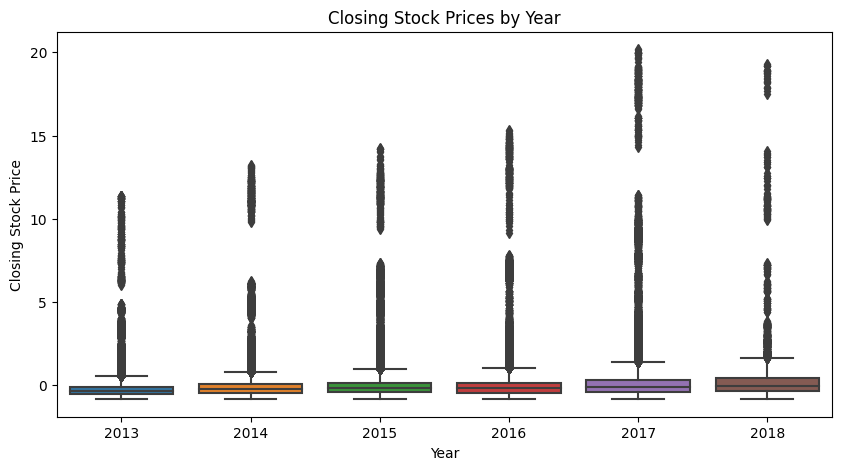

In [13]:

plt.figure(figsize=(10, 5))

stocksDF['year'] = stocksDF['date'].dt.year
sns.boxplot(x='year', y='close', data=stocksDF)
plt.title('Closing Stock Prices by Year')
plt.xlabel('Year')
plt.ylabel('Closing Stock Price')
plt.show()
